In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model

from collections import Counter

import tikzplotlib

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,5)
legend_fontsize = 16
plt.rcParams.update({'font.size': 16})

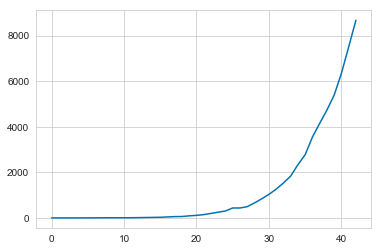

In [2]:
# Наблюдения
y = np.array([2,2,2,2,3,4,6,8,10,10,10,10,15,20,25,30,45,59,63,93,114,147,199,253,306,438,438,495,658,840,1036,1264,1534,1836,2337,2777,3548,4149,4731,5389,6343,7497,8672])
plt.plot(y)
T, N = len(y), 20000
init_rho, init_mu, init_beta = 0.01, 0.01, 0.00001
prior_rho_params = (1, 99)
prior_mu_params = (1, 99)
prior_beta_params = (1, 9999)

In [3]:
class SIR_MCMC:
    
    def __init__(self, prior_rho_params, prior_mu_params, prior_beta_params):
        self.param_names = ['rho', 'mu', 'beta']
        self.params = { 'rho' : prior_rho_params, 'mu' : prior_mu_params, 'beta' : prior_beta_params }
        self.params_history = { i : [x] for i,x in self.params.items() }        
        self._sample_parameters(use_means=True)

    def _sample_parameters(self, use_means=False):
        if use_means:
            self.rho, self.mu, self.beta = [ self.params[x][0] / (self.params[x][0] + self.params[x][1]) for x in self.param_names ]
        else:
            self.rho, self.mu, self.beta = [ np.random.beta(self.params[x][0], self.params[x][1]) for x in self.param_names ]
        
        self.logbeta = np.log(self.beta)
        self.logmu = np.log(self.mu)
        self.log1mbeta = np.log(1 - self.beta)
        self.log1mmu = np.log(1 - self.mu)

    def _sample_initial_trajectories(self):
        print("\t\t...rho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))
        iIter = 0
        while True:
            iIter += 1
            if iIter % 100 == 0:
                self._sample_parameters()
                print("\t\t...rho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))
            self.xs = np.zeros(shape=(self.N, 2)) - 1
            self.xs[0:self.y[0], 0] = 0
            self.arr_S, self.arr_I, self.arr_R = [self.N-self.y[0]], [self.y[0]], [0]
            
            for t in range(1, self.T):
                # переходы из S в I
                next_S_to_I = np.random.binomial(self.arr_S[-1], -np.expm1(self.arr_I[-1]*np.log(1-self.beta)) )

                # переходы из I в R
                next_I_to_R = np.random.binomial(self.arr_I[-1], self.mu)
                
                # проверяем, что вероятность такой последовательности не ноль
                if self.arr_I[-1] + next_S_to_I - next_I_to_R < self.y[t]:
                    break
                
                # обновляем траектории
                self.xs[self.arr_I[-1] + self.arr_R[-1]:self.arr_I[-1] + self.arr_R[-1] + next_S_to_I, 0] = t
                self.xs[self.arr_R[-1]:self.arr_R[-1] + next_I_to_R, 1] = t

                # обновляем массивы
                self.arr_S.append(self.arr_S[-1] - next_S_to_I)
                self.arr_I.append(self.arr_I[-1] + next_S_to_I - next_I_to_R)
                self.arr_R.append(self.arr_R[-1] + next_I_to_R)

            if len(self.arr_S) >= self.T:
                break

    def _update_state_arrays(self):
        self.arr_I = np.array([ np.sum(np.logical_and(np.logical_and(self.xs[:,0] >= 0, self.xs[:,0] <= t), np.logical_or(self.xs[:,1] < 0, self.xs[:,1] >= t))) for t in range(self.T)])
        self.arr_S = np.array([ np.sum(np.logical_or(self.xs[:,0] < 0, self.xs[:,0] > t)) for t in range(self.T)])
        self.arr_R = self.N - self.arr_I - self.arr_S
                
    def _compute_Q_matrices(self, ind_x):
        cur_x = self.xs[ind_x]
        
        ## считаем всё в логарифмах
        qs = np.zeros(shape=(self.T, 3, 3)) - np.inf
        if cur_x[0] == 0:
            qs[0,0,1] = 0.0
        else:
            qs[0,0,0] = 0.0

        if cur_x[1] == -1:
            if cur_x[0] > -1:
                arr_I_without_current = self.arr_I - np.array( np.arange(self.T) >= cur_x[0], dtype=int)
            else:
                arr_I_without_current = self.arr_I
        else:
            arr_I_without_current = self.arr_I - np.array( np.logical_and(np.arange(self.T) >= cur_x[0], np.arange(self.T) < cur_x[1]), dtype=int)
        
        for t in range(1, self.T):
            logprob_y_without_current = sp.stats.binom.logpmf(self.y[t], arr_I_without_current[t], self.rho)
            logprob_y_with_current = sp.stats.binom.logpmf(self.y[t], arr_I_without_current[t]+1, self.rho)
            qs[t] = -np.inf
            if qs[t-1, 0, 0] > -np.inf:
                logprob_stay_healthy = arr_I_without_current[t-1] * self.log1mbeta
                qs[t, 0, 0] = (qs[t-1, 0, 0]) + logprob_stay_healthy + logprob_y_without_current
                qs[t, 0, 1] = (qs[t-1, 0, 0]) + np.log(-np.expm1(logprob_stay_healthy)) + logprob_y_with_current
            prob_prev_I_state, prob_prev_R_state = np.logaddexp.reduce(qs[t-1, :, 1]), np.logaddexp.reduce(qs[t-1, :, 2])
            if prob_prev_I_state > -np.inf:
                qs[t, 1, 1] = (prob_prev_I_state) + self.log1mmu + logprob_y_with_current
                qs[t, 1, 2] = (prob_prev_I_state) + self.logmu + logprob_y_without_current
            if prob_prev_R_state > -np.inf:
                qs[t, 2, 2] = (prob_prev_R_state) + logprob_y_without_current
            qs[t] = qs[t] - np.logaddexp.reduce(qs[t], axis=(0,1))

        ## экспоненту берём только на выходе
        return np.exp(qs)
          
    def _sample_new_x(self, qs):        
#         print(qs)
        new_x = np.zeros(2)
        cur_state = np.random.choice(3, p=np.sum(qs[self.T-1], axis=1))
        new_x[cur_state:] = -1
        for t in range(T-2, -1, -1):
            new_state = np.random.choice(3, p=qs[t+1,:,cur_state] / np.sum(qs[t+1,:,cur_state]))
            if new_state < cur_state:
                new_x[new_state] = t+1
                cur_state = new_state
            if new_state == 0:
                break
        return new_x

    def _update_state_arrays(self):
        self.arr_S = np.array([ np.sum(np.logical_or(self.xs[:,0] < 0, self.xs[:,0] > t)) for t in range(self.T)])
        self.arr_R = np.array([ np.sum(np.logical_and(self.xs[:,1] >= 0, self.xs[:,1] <= t)) for t in range(self.T)])
        self.arr_I = self.N - self.arr_S - self.arr_R

    def _metropolis_hastings_loop(self, iters):
        for _ in range(iters):
            x_index = np.random.randint(self.N)
            qs = self._compute_Q_matrices(x_index)
            new_x = self._sample_new_x(qs)
            if True: ## metropolis ratio? does it apply?
                self.xs[x_index] = new_x
                self._update_state_arrays()

    ## обновляем параметры модели
    def _update_model_parameters(self):
        # сколько человек заболело и не заболело в каждый момент
        indices_infections =  np.array( self.xs[self.y[0]:,0]-1, dtype=int )
        counter_stayhealthy = Counter( [ i for x in indices_infections for i in range(0, x)] )
        counter_infections = Counter( indices_infections )
        
        # сколько ожидаемых инфицирований на каждого инфицированного
        expected_infections = np.divide( self.beta*self.arr_I, -np.expm1( self.arr_I * self.log1mbeta ) )
        expected_infections[ np.where(self.arr_I == 1) ] = 1
        expected_infections[ np.where(self.arr_I == 0) ] = 0

        # суммарные ожидаемые числа событий инфицирований и не-инфицирований
        expected_num_I_infections = np.sum([ x * expected_infections[i] for i,x in counter_infections.items()])
        expected_num_I_notinfections = np.sum([x * (self.arr_I[i] - expected_infections[i]) for i,x in counter_infections.items()])
        expected_num_S_notinfections = np.sum([ x * self.arr_I[i] for i,x in counter_stayhealthy.items() ])
                
        for x in self.param_names:
            self.params_history[x].append(self.params[x])
        current_param_updates = {
            'rho': ( np.sum(self.y), np.sum(self.arr_I) - np.sum(self.y) ),
            'mu': ( np.sum(np.diff(self.arr_R)), np.sum(self.arr_I[:-1]) - np.sum(np.diff(self.arr_R)) ),
            'beta': ( expected_num_I_infections, expected_num_I_notinfections + expected_num_S_notinfections )
        }
        for x in self.param_names:
            self.params[x] = (self.params_history[x][0][0] + current_param_updates[x][0], self.params_history[x][0][1] + current_param_updates[x][1])

            
    ### the main loop
    def fit(self, y, N, iters=3, mh_iters=500, burn_in=500, verbose=True):
        self.y, self.N, self.T = y, N, y.shape[0]
        self._sample_initial_trajectories()
        
        if verbose:
            print("Initial values:\trho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))

        self._metropolis_hastings_loop(burn_in)
            
        for iIter in range(iters):
            self._metropolis_hastings_loop(mh_iters)
            self._update_model_parameters()
            if verbose:
                print('New params: %s' % "\t".join(["%s: (%.2f,%.2f)" % (x, self.params[x][0], self.params[x][1]) for x in self.param_names]))
            self._sample_parameters(use_means=True)
            if verbose:
                print("Iteration %2d:\trho = %.6f\tmu = %.6f\tbeta = %.6f" % (iIter, self.rho, self.mu, self.beta))


In [4]:
def sample_population(N, T, true_rho, true_beta, true_mu):
    true_log1mbeta = np.log(1 - true_beta)

    cur_states = np.zeros(N)
    cur_states[:1] = 1
    cur_I, test_y, true_statistics = 1, [1], [[N-1, 1, 0]]

    for t in range(T):    
        logprob_stay_healthy = cur_I * true_log1mbeta
        for i in range(N):
            if cur_states[i] == 0 and np.random.rand() < -np.expm1(logprob_stay_healthy):
                cur_states[i] = 1
            elif cur_states[i] == 1 and np.random.rand() < true_mu:
                cur_states[i] = 2

        cur_I = np.sum(cur_states == 1)
        test_y.append( np.random.binomial( cur_I, true_rho ) )
        true_statistics.append([np.sum(cur_states == 0), np.sum(cur_states == 1), np.sum(cur_states == 2)])

    return test_y, np.array(true_statistics).T

[ 1  1  4 15  7  4  4  6  4  1  3  1  1  2  2  2  0  2  1  0  0]


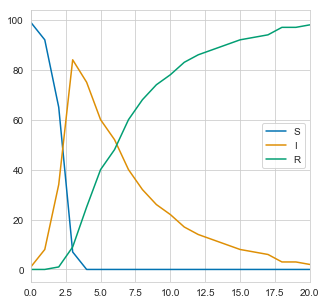

In [19]:
N, T, true_rho, true_beta, true_mu = 100, 20, 0.1, 0.05, 0.2
test_y, true_statistics = sample_population(N, T, true_rho, true_beta, true_mu)
print(np.array(test_y))
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(true_statistics.T)
ax.legend(["S", "I", "R"])
ax.set_xlim((0, 20))
fig.savefig('covid1.pdf', bbox_inches='tight')

In [20]:
print("True values: rho=%.4f\tmu=%.4f\tbeta=%.4f" % (true_rho, true_mu, true_beta))
print("Y = %s" % test_y)
model = SIR_MCMC((1, 1), (1, 1), (1, 1))
model.fit(np.array(test_y), N, iters=1000, mh_iters=int(N/10), burn_in=2*N)

True values: rho=0.1000	mu=0.2000	beta=0.0500
Y = [1, 1, 4, 15, 7, 4, 4, 6, 4, 1, 3, 1, 1, 2, 2, 2, 0, 2, 1, 0, 0]
		...rho = 0.500000	mu = 0.500000	beta = 0.500000
		...rho = 0.147798	mu = 0.275801	beta = 0.680289
Initial values:	rho = 0.147798	mu = 0.275801	beta = 0.680289


/usr/lib/python3/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


New params: rho: (62.00,371.00)	mu: (99.00,332.00)	beta: (1592.57,752.43)
Iteration  0:	rho = 0.143187	mu = 0.229698	beta = 0.679134
New params: rho: (62.00,385.00)	mu: (98.00,346.00)	beta: (1628.72,776.28)
Iteration  1:	rho = 0.138702	mu = 0.220721	beta = 0.677224
New params: rho: (62.00,391.00)	mu: (98.00,352.00)	beta: (1624.32,780.68)
Iteration  2:	rho = 0.136865	mu = 0.217778	beta = 0.675395
New params: rho: (62.00,426.00)	mu: (97.00,387.00)	beta: (1637.35,794.65)
Iteration  3:	rho = 0.127049	mu = 0.200413	beta = 0.673250
New params: rho: (62.00,439.00)	mu: (96.00,400.00)	beta: (1662.66,817.34)
Iteration  4:	rho = 0.123752	mu = 0.193548	beta = 0.670429
New params: rho: (62.00,451.00)	mu: (96.00,412.00)	beta: (1669.03,831.97)
Iteration  5:	rho = 0.120858	mu = 0.188976	beta = 0.667345
New params: rho: (62.00,451.00)	mu: (96.00,412.00)	beta: (1673.31,846.69)
Iteration  6:	rho = 0.120858	mu = 0.188976	beta = 0.664010
New params: rho: (62.00,450.00)	mu: (96.00,411.00)	beta: (1684.49,867

New params: rho: (62.00,685.00)	mu: (92.00,646.00)	beta: (1327.33,1257.67)
Iteration 64:	rho = 0.082999	mu = 0.124661	beta = 0.513473
New params: rho: (62.00,702.00)	mu: (90.00,663.00)	beta: (1326.06,1265.94)
Iteration 65:	rho = 0.081152	mu = 0.119522	beta = 0.511597
New params: rho: (62.00,728.00)	mu: (90.00,689.00)	beta: (1321.39,1270.61)
Iteration 66:	rho = 0.078481	mu = 0.115533	beta = 0.509795
New params: rho: (62.00,704.00)	mu: (90.00,665.00)	beta: (1312.33,1272.67)
Iteration 67:	rho = 0.080940	mu = 0.119205	beta = 0.507672
New params: rho: (62.00,697.00)	mu: (89.00,658.00)	beta: (1311.61,1280.39)
Iteration 68:	rho = 0.081686	mu = 0.119143	beta = 0.506022
New params: rho: (62.00,704.00)	mu: (88.00,665.00)	beta: (1311.03,1285.97)
Iteration 69:	rho = 0.080940	mu = 0.116866	beta = 0.504826
New params: rho: (62.00,727.00)	mu: (87.00,688.00)	beta: (1308.04,1288.96)
Iteration 70:	rho = 0.078580	mu = 0.112258	beta = 0.503675
New params: rho: (62.00,716.00)	mu: (87.00,677.00)	beta: (1305

New params: rho: (62.00,659.00)	mu: (93.00,620.00)	beta: (1312.48,1287.52)
Iteration 127:	rho = 0.085992	mu = 0.130435	beta = 0.504801
New params: rho: (62.00,673.00)	mu: (93.00,634.00)	beta: (1312.50,1287.50)
Iteration 128:	rho = 0.084354	mu = 0.127923	beta = 0.504807
New params: rho: (62.00,684.00)	mu: (92.00,645.00)	beta: (1312.51,1287.49)
Iteration 129:	rho = 0.083110	mu = 0.124830	beta = 0.504813
New params: rho: (62.00,639.00)	mu: (93.00,600.00)	beta: (1312.01,1284.99)
Iteration 130:	rho = 0.088445	mu = 0.134199	beta = 0.505203
New params: rho: (62.00,656.00)	mu: (93.00,617.00)	beta: (1311.46,1280.54)
Iteration 131:	rho = 0.086351	mu = 0.130986	beta = 0.505965
New params: rho: (62.00,651.00)	mu: (94.00,612.00)	beta: (1302.82,1282.18)
Iteration 132:	rho = 0.086957	mu = 0.133144	beta = 0.503991
New params: rho: (62.00,602.00)	mu: (97.00,563.00)	beta: (1297.91,1287.09)
Iteration 133:	rho = 0.093373	mu = 0.146970	beta = 0.502094
New params: rho: (62.00,570.00)	mu: (98.00,531.00)	beta

New params: rho: (62.00,526.00)	mu: (97.00,487.00)	beta: (1202.51,1349.49)
Iteration 191:	rho = 0.105442	mu = 0.166096	beta = 0.471201
New params: rho: (62.00,567.00)	mu: (98.00,528.00)	beta: (1211.22,1364.78)
Iteration 192:	rho = 0.098569	mu = 0.156550	beta = 0.470195
New params: rho: (62.00,546.00)	mu: (99.00,507.00)	beta: (1208.73,1367.27)
Iteration 193:	rho = 0.101974	mu = 0.163366	beta = 0.469229
New params: rho: (62.00,583.00)	mu: (97.00,544.00)	beta: (1211.56,1373.44)
Iteration 194:	rho = 0.096124	mu = 0.151326	beta = 0.468690
New params: rho: (62.00,612.00)	mu: (95.00,573.00)	beta: (1205.01,1370.99)
Iteration 195:	rho = 0.091988	mu = 0.142216	beta = 0.467783
New params: rho: (62.00,588.00)	mu: (96.00,549.00)	beta: (1212.25,1379.75)
Iteration 196:	rho = 0.095385	mu = 0.148837	beta = 0.467688
New params: rho: (62.00,573.00)	mu: (96.00,534.00)	beta: (1202.53,1373.47)
Iteration 197:	rho = 0.097638	mu = 0.152381	beta = 0.466819
New params: rho: (62.00,565.00)	mu: (96.00,526.00)	beta

New params: rho: (62.00,556.00)	mu: (97.00,517.00)	beta: (1128.35,1447.65)
Iteration 256:	rho = 0.100324	mu = 0.157980	beta = 0.438024
New params: rho: (62.00,522.00)	mu: (97.00,483.00)	beta: (1138.12,1453.88)
Iteration 257:	rho = 0.106164	mu = 0.167241	beta = 0.439088
New params: rho: (62.00,514.00)	mu: (98.00,475.00)	beta: (1143.96,1453.04)
Iteration 258:	rho = 0.107639	mu = 0.171030	beta = 0.440495
New params: rho: (62.00,526.00)	mu: (97.00,487.00)	beta: (1151.24,1449.76)
Iteration 259:	rho = 0.105442	mu = 0.166096	beta = 0.442613
New params: rho: (62.00,507.00)	mu: (98.00,468.00)	beta: (1157.09,1442.91)
Iteration 260:	rho = 0.108963	mu = 0.173145	beta = 0.445035
New params: rho: (62.00,523.00)	mu: (98.00,484.00)	beta: (1162.59,1438.41)
Iteration 261:	rho = 0.105983	mu = 0.168385	beta = 0.446977
New params: rho: (62.00,514.00)	mu: (98.00,475.00)	beta: (1156.29,1428.71)
Iteration 262:	rho = 0.107639	mu = 0.171030	beta = 0.447308
New params: rho: (62.00,489.00)	mu: (98.00,450.00)	beta

New params: rho: (62.00,559.00)	mu: (93.00,520.00)	beta: (1191.98,1405.02)
Iteration 320:	rho = 0.099839	mu = 0.151713	beta = 0.458984
New params: rho: (62.00,554.00)	mu: (93.00,515.00)	beta: (1197.46,1403.54)
Iteration 321:	rho = 0.100649	mu = 0.152961	beta = 0.460385
New params: rho: (62.00,534.00)	mu: (94.00,495.00)	beta: (1200.96,1400.04)
Iteration 322:	rho = 0.104027	mu = 0.159593	beta = 0.461731
New params: rho: (62.00,487.00)	mu: (95.00,448.00)	beta: (1204.48,1392.52)
Iteration 323:	rho = 0.112933	mu = 0.174954	beta = 0.463797
New params: rho: (62.00,486.00)	mu: (96.00,447.00)	beta: (1209.64,1387.36)
Iteration 324:	rho = 0.113139	mu = 0.176796	beta = 0.465782
New params: rho: (62.00,493.00)	mu: (96.00,454.00)	beta: (1212.99,1387.01)
Iteration 325:	rho = 0.111712	mu = 0.174545	beta = 0.466535
New params: rho: (62.00,508.00)	mu: (95.00,469.00)	beta: (1216.34,1384.66)
Iteration 326:	rho = 0.108772	mu = 0.168440	beta = 0.467642
New params: rho: (62.00,524.00)	mu: (95.00,485.00)	beta

New params: rho: (62.00,663.00)	mu: (91.00,624.00)	beta: (837.28,1507.72)
Iteration 384:	rho = 0.085517	mu = 0.127273	beta = 0.357051
New params: rho: (62.00,674.00)	mu: (91.00,635.00)	beta: (879.21,1577.79)
Iteration 385:	rho = 0.084239	mu = 0.125344	beta = 0.357840
New params: rho: (62.00,673.00)	mu: (92.00,634.00)	beta: (860.46,1544.54)
Iteration 386:	rho = 0.084354	mu = 0.126722	beta = 0.357781
New params: rho: (62.00,706.00)	mu: (92.00,667.00)	beta: (824.05,1487.95)
Iteration 387:	rho = 0.080729	mu = 0.121212	beta = 0.356425
New params: rho: (62.00,698.00)	mu: (92.00,659.00)	beta: (867.83,1564.17)
Iteration 388:	rho = 0.081579	mu = 0.122503	beta = 0.356836
New params: rho: (62.00,696.00)	mu: (93.00,657.00)	beta: (858.15,1546.85)
Iteration 389:	rho = 0.081794	mu = 0.124000	beta = 0.356820
New params: rho: (62.00,688.00)	mu: (92.00,649.00)	beta: (846.76,1529.24)
Iteration 390:	rho = 0.082667	mu = 0.124157	beta = 0.356382
New params: rho: (62.00,671.00)	mu: (91.00,632.00)	beta: (807.

New params: rho: (62.00,494.00)	mu: (98.00,455.00)	beta: (699.40,1540.60)
Iteration 447:	rho = 0.111511	mu = 0.177215	beta = 0.312234
New params: rho: (62.00,504.00)	mu: (99.00,465.00)	beta: (642.44,1429.56)
Iteration 448:	rho = 0.109541	mu = 0.175532	beta = 0.310057
New params: rho: (62.00,483.00)	mu: (100.00,444.00)	beta: (667.42,1492.58)
Iteration 449:	rho = 0.113761	mu = 0.183824	beta = 0.308991
New params: rho: (62.00,481.00)	mu: (100.00,442.00)	beta: (665.23,1494.77)
Iteration 450:	rho = 0.114180	mu = 0.184502	beta = 0.307975
New params: rho: (62.00,490.00)	mu: (100.00,451.00)	beta: (648.90,1468.10)
Iteration 451:	rho = 0.112319	mu = 0.181488	beta = 0.306518
New params: rho: (62.00,490.00)	mu: (99.00,451.00)	beta: (660.14,1499.86)
Iteration 452:	rho = 0.112319	mu = 0.180000	beta = 0.305619
New params: rho: (62.00,514.00)	mu: (99.00,475.00)	beta: (671.81,1529.19)
Iteration 453:	rho = 0.107639	mu = 0.172474	beta = 0.305230
New params: rho: (62.00,510.00)	mu: (99.00,471.00)	beta: (6

/usr/lib/python3/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


New params: rho: (62.00,517.00)	mu: (98.00,478.00)	beta: (625.46,1491.54)
Iteration 462:	rho = 0.107081	mu = 0.170139	beta = 0.295447
New params: rho: (62.00,530.00)	mu: (98.00,491.00)	beta: (594.50,1430.50)
Iteration 463:	rho = 0.104730	mu = 0.166384	beta = 0.293582
New params: rho: (62.00,490.00)	mu: (100.00,451.00)	beta: (619.90,1497.10)
Iteration 464:	rho = 0.112319	mu = 0.181488	beta = 0.292818
New params: rho: (62.00,487.00)	mu: (99.00,448.00)	beta: (644.94,1556.06)
Iteration 465:	rho = 0.112933	mu = 0.180987	beta = 0.293020
New params: rho: (62.00,508.00)	mu: (98.00,469.00)	beta: (657.78,1582.22)
Iteration 466:	rho = 0.108772	mu = 0.172840	beta = 0.293653
New params: rho: (62.00,474.00)	mu: (99.00,435.00)	beta: (692.96,1652.04)
Iteration 467:	rho = 0.115672	mu = 0.185393	beta = 0.295507
New params: rho: (62.00,512.00)	mu: (99.00,473.00)	beta: (663.10,1576.90)
Iteration 468:	rho = 0.108014	mu = 0.173077	beta = 0.296027
New params: rho: (62.00,530.00)	mu: (99.00,491.00)	beta: (676

New params: rho: (62.00,576.00)	mu: (96.00,537.00)	beta: (761.42,1478.58)
Iteration 524:	rho = 0.097179	mu = 0.151659	beta = 0.339921
New params: rho: (62.00,587.00)	mu: (96.00,548.00)	beta: (728.90,1431.10)
Iteration 525:	rho = 0.095532	mu = 0.149068	beta = 0.337454
New params: rho: (62.00,620.00)	mu: (95.00,581.00)	beta: (738.66,1462.34)
Iteration 526:	rho = 0.090909	mu = 0.140533	beta = 0.335600
New params: rho: (62.00,653.00)	mu: (92.00,614.00)	beta: (725.70,1445.30)
Iteration 527:	rho = 0.086713	mu = 0.130312	beta = 0.334268
New params: rho: (62.00,649.00)	mu: (93.00,610.00)	beta: (749.67,1495.33)
Iteration 528:	rho = 0.087201	mu = 0.132290	beta = 0.333930
New params: rho: (62.00,682.00)	mu: (91.00,643.00)	beta: (707.88,1423.12)
Iteration 529:	rho = 0.083333	mu = 0.123978	beta = 0.332183
New params: rho: (62.00,686.00)	mu: (91.00,647.00)	beta: (704.34,1426.66)
Iteration 530:	rho = 0.082888	mu = 0.123306	beta = 0.330520
New params: rho: (62.00,691.00)	mu: (90.00,652.00)	beta: (715.

New params: rho: (62.00,352.00)	mu: (101.00,313.00)	beta: (420.28,1339.72)
Iteration 588:	rho = 0.149758	mu = 0.243961	beta = 0.238797
New params: rho: (62.00,362.00)	mu: (101.00,323.00)	beta: (442.20,1406.80)
Iteration 589:	rho = 0.146226	mu = 0.238208	beta = 0.239158
New params: rho: (62.00,363.00)	mu: (100.00,324.00)	beta: (429.13,1365.87)
Iteration 590:	rho = 0.145882	mu = 0.235849	beta = 0.239068
New params: rho: (62.00,372.00)	mu: (99.00,333.00)	beta: (428.98,1366.02)
Iteration 591:	rho = 0.142857	mu = 0.229167	beta = 0.238985
New params: rho: (62.00,377.00)	mu: (99.00,338.00)	beta: (428.84,1366.16)
Iteration 592:	rho = 0.141230	mu = 0.226545	beta = 0.238907
New params: rho: (62.00,362.00)	mu: (100.00,323.00)	beta: (414.60,1324.40)
Iteration 593:	rho = 0.146226	mu = 0.236407	beta = 0.238413
New params: rho: (62.00,413.00)	mu: (99.00,374.00)	beta: (384.45,1236.55)
Iteration 594:	rho = 0.130526	mu = 0.209302	beta = 0.237168
New params: rho: (62.00,418.00)	mu: (98.00,379.00)	beta: (

New params: rho: (62.00,661.00)	mu: (92.00,622.00)	beta: (334.36,1524.64)
Iteration 650:	rho = 0.085754	mu = 0.128852	beta = 0.179862
New params: rho: (62.00,645.00)	mu: (93.00,606.00)	beta: (318.69,1448.31)
Iteration 651:	rho = 0.087694	mu = 0.133047	beta = 0.180354
New params: rho: (62.00,663.00)	mu: (93.00,624.00)	beta: (319.43,1447.57)
Iteration 652:	rho = 0.085517	mu = 0.129707	beta = 0.180773
New params: rho: (62.00,655.00)	mu: (94.00,616.00)	beta: (330.97,1499.03)
Iteration 653:	rho = 0.086471	mu = 0.132394	beta = 0.180858
New params: rho: (62.00,662.00)	mu: (93.00,623.00)	beta: (309.44,1394.56)
Iteration 654:	rho = 0.085635	mu = 0.129888	beta = 0.181596
New params: rho: (62.00,643.00)	mu: (95.00,604.00)	beta: (353.94,1598.06)
Iteration 655:	rho = 0.087943	mu = 0.135908	beta = 0.181322
New params: rho: (62.00,669.00)	mu: (95.00,630.00)	beta: (360.75,1608.25)
Iteration 656:	rho = 0.084815	mu = 0.131034	beta = 0.183216
New params: rho: (62.00,648.00)	mu: (95.00,609.00)	beta: (383.

New params: rho: (62.00,564.00)	mu: (96.00,525.00)	beta: (574.97,1626.03)
Iteration 714:	rho = 0.099042	mu = 0.154589	beta = 0.261229
New params: rho: (62.00,588.00)	mu: (96.00,549.00)	beta: (566.95,1593.05)
Iteration 715:	rho = 0.095385	mu = 0.148837	beta = 0.262479
New params: rho: (62.00,554.00)	mu: (98.00,515.00)	beta: (544.48,1527.52)
Iteration 716:	rho = 0.100649	mu = 0.159869	beta = 0.262782
New params: rho: (62.00,570.00)	mu: (97.00,531.00)	beta: (570.15,1589.85)
Iteration 717:	rho = 0.098101	mu = 0.154459	beta = 0.263957
New params: rho: (62.00,596.00)	mu: (97.00,557.00)	beta: (560.24,1556.76)
Iteration 718:	rho = 0.094225	mu = 0.148318	beta = 0.264637
New params: rho: (62.00,565.00)	mu: (97.00,526.00)	beta: (535.33,1489.67)
Iteration 719:	rho = 0.098884	mu = 0.155698	beta = 0.264363
New params: rho: (62.00,563.00)	mu: (96.00,524.00)	beta: (506.50,1418.50)
Iteration 720:	rho = 0.099200	mu = 0.154839	beta = 0.263118
New params: rho: (62.00,557.00)	mu: (97.00,518.00)	beta: (504.

New params: rho: (62.00,710.00)	mu: (88.00,671.00)	beta: (499.56,1617.44)
Iteration 777:	rho = 0.080311	mu = 0.115942	beta = 0.235977
New params: rho: (62.00,707.00)	mu: (89.00,668.00)	beta: (492.44,1579.56)
Iteration 778:	rho = 0.080624	mu = 0.117569	beta = 0.237662
New params: rho: (62.00,718.00)	mu: (89.00,679.00)	beta: (471.12,1504.88)
Iteration 779:	rho = 0.079487	mu = 0.115885	beta = 0.238421
New params: rho: (62.00,705.00)	mu: (90.00,666.00)	beta: (446.05,1425.95)
Iteration 780:	rho = 0.080834	mu = 0.119048	beta = 0.238274
New params: rho: (62.00,661.00)	mu: (92.00,622.00)	beta: (445.79,1426.21)
Iteration 781:	rho = 0.085754	mu = 0.128852	beta = 0.238137
New params: rho: (62.00,613.00)	mu: (95.00,574.00)	beta: (459.00,1466.00)
Iteration 782:	rho = 0.091852	mu = 0.142003	beta = 0.238440
New params: rho: (62.00,632.00)	mu: (94.00,593.00)	beta: (449.58,1462.42)
Iteration 783:	rho = 0.089337	mu = 0.136827	beta = 0.235136
New params: rho: (62.00,688.00)	mu: (93.00,649.00)	beta: (447.

New params: rho: (62.00,492.00)	mu: (98.00,453.00)	beta: (270.62,1102.38)
Iteration 839:	rho = 0.111913	mu = 0.177858	beta = 0.197103
New params: rho: (62.00,474.00)	mu: (98.00,435.00)	beta: (309.14,1274.86)
Iteration 840:	rho = 0.115672	mu = 0.183865	beta = 0.195161
New params: rho: (62.00,479.00)	mu: (98.00,440.00)	beta: (334.22,1413.78)
Iteration 841:	rho = 0.114603	mu = 0.182156	beta = 0.191201
New params: rho: (62.00,496.00)	mu: (99.00,457.00)	beta: (314.84,1346.16)
Iteration 842:	rho = 0.111111	mu = 0.178058	beta = 0.189549
New params: rho: (62.00,474.00)	mu: (99.00,435.00)	beta: (297.16,1266.84)
Iteration 843:	rho = 0.115672	mu = 0.185393	beta = 0.190002
New params: rho: (62.00,500.00)	mu: (98.00,461.00)	beta: (331.22,1403.78)
Iteration 844:	rho = 0.110320	mu = 0.175313	beta = 0.190905
New params: rho: (62.00,504.00)	mu: (98.00,465.00)	beta: (357.69,1529.31)
Iteration 845:	rho = 0.109541	mu = 0.174067	beta = 0.189554
New params: rho: (62.00,524.00)	mu: (97.00,485.00)	beta: (377.

New params: rho: (62.00,475.00)	mu: (99.00,436.00)	beta: (308.98,2211.02)
Iteration 901:	rho = 0.115456	mu = 0.185047	beta = 0.122611
New params: rho: (62.00,490.00)	mu: (99.00,451.00)	beta: (300.94,2091.06)
Iteration 902:	rho = 0.112319	mu = 0.180000	beta = 0.125812
New params: rho: (62.00,487.00)	mu: (99.00,448.00)	beta: (312.81,2156.19)
Iteration 903:	rho = 0.112933	mu = 0.180987	beta = 0.126694
New params: rho: (62.00,482.00)	mu: (99.00,443.00)	beta: (307.91,2094.09)
Iteration 904:	rho = 0.113971	mu = 0.182657	beta = 0.128189
New params: rho: (62.00,468.00)	mu: (99.00,429.00)	beta: (310.71,2091.29)
Iteration 905:	rho = 0.116981	mu = 0.187500	beta = 0.129354
New params: rho: (62.00,465.00)	mu: (98.00,426.00)	beta: (310.36,2083.64)
Iteration 906:	rho = 0.117647	mu = 0.187023	beta = 0.129639
New params: rho: (62.00,475.00)	mu: (98.00,436.00)	beta: (310.89,2083.11)
Iteration 907:	rho = 0.115456	mu = 0.183521	beta = 0.129861
New params: rho: (62.00,480.00)	mu: (98.00,441.00)	beta: (296.

New params: rho: (62.00,481.00)	mu: (98.00,442.00)	beta: (311.70,2644.30)
Iteration 963:	rho = 0.114180	mu = 0.181481	beta = 0.105447
New params: rho: (62.00,535.00)	mu: (97.00,496.00)	beta: (290.38,2399.62)
Iteration 964:	rho = 0.103853	mu = 0.163575	beta = 0.107950
New params: rho: (62.00,561.00)	mu: (96.00,522.00)	beta: (300.47,2451.53)
Iteration 965:	rho = 0.099518	mu = 0.155340	beta = 0.109183
New params: rho: (62.00,522.00)	mu: (98.00,483.00)	beta: (309.84,2519.16)
Iteration 966:	rho = 0.106164	mu = 0.168675	beta = 0.109522
New params: rho: (62.00,496.00)	mu: (98.00,457.00)	beta: (315.00,2589.00)
Iteration 967:	rho = 0.111111	mu = 0.176577	beta = 0.108472
New params: rho: (62.00,488.00)	mu: (98.00,449.00)	beta: (302.02,2484.98)
Iteration 968:	rho = 0.112727	mu = 0.179159	beta = 0.108369
New params: rho: (62.00,500.00)	mu: (98.00,461.00)	beta: (292.37,2372.63)
Iteration 969:	rho = 0.110320	mu = 0.175313	beta = 0.109707
New params: rho: (62.00,548.00)	mu: (97.00,509.00)	beta: (296.

In [33]:
def beta_mean(x):
    return x[0] / (x[0] + x[1])

true_params ={'rho' : true_rho, 'mu': true_mu, 'beta' : true_beta}

def plot_model_params_history(ax, model, true_params=None):
    ## нарисуем, как менялись параметры модели со временем
    for i, name in enumerate(model.param_names):
        ax.plot([beta_mean(x) for x in model.params_history[name]], color=palette[i])
        if true_params is not None:
            ax.hlines(true_params[name], xmin=0, xmax=len(model.params_history[name]), linestyle='dashed', color=palette[i])
    ax.legend(model.param_names)

{'rho': 0.1, 'mu': 0.2, 'beta': 0.05}
rho: global=0.10026	last100=0.11283
mu: global=0.15585	last100=0.17960
beta: global=0.33749	last100=0.11433


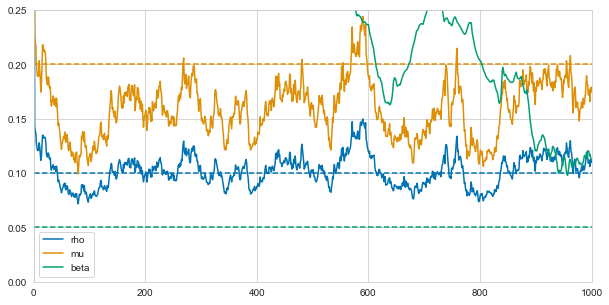

In [34]:
print(true_params)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_model_params_history(ax, model, true_params)
ax.set_ylim((0, 0.25))
ax.set_xlim((0, 1000))
fig.savefig('covid2.pdf', bbox_inches='tight')

for i, name in enumerate(model.param_names):
    print("%s: global=%.05f\tlast100=%.05f" % (name, beta_mean( (np.sum([x[0] for x in model.params_history[name]]), np.sum([x[1] for x in model.params_history[name]]) )), beta_mean( (np.sum([x[0] for x in model.params_history[name][-100:]]), np.sum([x[1] for x in model.params_history[name][-100:]]) ))   ))

In [36]:
def plot_model_and_true_arrays(ax, true_stats, model):
    for i,line in enumerate(true_stats):
        ax.plot(line, color=palette[i])
    for i,line in enumerate([model.arr_S, model.arr_I, model.arr_R]):
        ax.plot(line, color=palette[i], linestyle='dashed')
    ax.legend(["S", "I", "R", "S model", "I model", "R model"])

Observed data: [1, 1, 4, 15, 7, 4, 4, 6, 4, 1, 3, 1, 1, 2, 2, 2, 0, 2, 1, 0, 0]
Average sample from true parameters (dev=6.4368):
[1.    0.618 2.808 7.106 7.532 6.302 5.092 4.002 3.326 2.614 2.054 1.59
 1.344 0.946 0.84  0.678 0.508 0.4   0.31  0.31  0.22 ]
Average sample from model parameters (dev=6.1689):
[1.    1.324 7.994 9.128 7.334 6.114 5.1   4.154 3.628 2.916 2.428 2.002
 1.618 1.34  0.99  0.956 0.758 0.598 0.472 0.438 0.362]
Average sample from mean parameters (dev=6.3916):
[1.    1.322 8.696 9.376 7.684 6.372 5.124 4.246 3.618 2.802 2.362 2.048
 1.642 1.388 1.128 0.932 0.744 0.622 0.5   0.418 0.376]


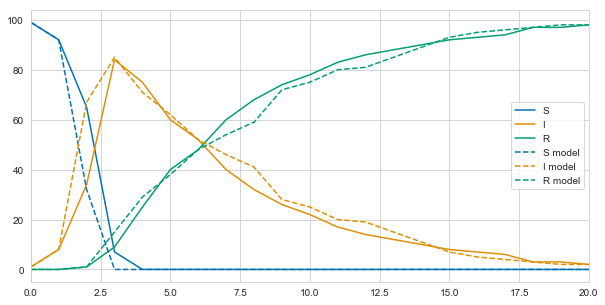

In [37]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_model_and_true_arrays(ax, true_statistics, model)
ax.set_xlim((0, 20))
fig.savefig('covid3.pdf', bbox_inches='tight')

mean_params = {
   name : beta_mean( (np.sum([x[0] for x in model.params_history[name][-100:]]), np.sum([x[1] for x in model.params_history[name][-100:]]) ))
    for name in model.param_names }

print("Observed data: %s" % test_y)
true_sample, model_sample, mean_sample = [], [], []
for _ in range(500):
    model_sample.append(sample_population(N, T, model.rho, model.beta, model.mu)[0])
    true_sample.append(sample_population(N, T, true_rho, true_beta, true_mu)[0])
    mean_sample.append(sample_population(N, T, mean_params['rho'], mean_params['beta'], mean_params['mu'])[0])
    
print("Average sample from true parameters (dev=%.4f):\n%s" % (np.mean((np.array(true_sample)-test_y)**2), np.mean(np.array(true_sample), axis=0)))
print("Average sample from model parameters (dev=%.4f):\n%s" % (np.mean((np.array(model_sample)-test_y)**2), np.mean(np.array(model_sample), axis=0)))
print("Average sample from mean parameters (dev=%.4f):\n%s" % (np.mean((np.array(mean_sample)-test_y)**2), np.mean(np.array(mean_sample), axis=0)))